In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sm

In [2]:
from platform import python_version
>>> print(python_version())

3.7.3


## Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined.

The aim is to build a predictive model and find out the sales of each product at a particular store.
Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

In [3]:
train = pd.read_csv(r"D:\GreatLearning\Datasets\big-mart-sales-prediction\Train.csv")

In [4]:
test = pd.read_csv(r"D:\GreatLearning\Datasets\big-mart-sales-prediction\Test.csv")

In [5]:
data = pd.concat([train,test],sort = False, ignore_index=True)

In [6]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
answer = pd.read_csv(r"D:\GreatLearning\Datasets\big-mart-sales-prediction\Submission.csv")

In [8]:
answer.head()

,Unnamed: 0,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,0,FDW58,OUT049,1636.244023
1,1,FDW14,OUT017,1409.355910
2,2,NCN55,OUT010,710.594286
3,3,FDQ58,OUT017,2355.184955
4,4,FDY38,OUT027,5857.916205


In [9]:
data.shape

(14204, 12)

In [10]:
train.shape

(8523, 12)

In [11]:
test.shape

(5681, 11)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
Item_Identifier              14204 non-null object
Item_Weight                  11765 non-null float64
Item_Fat_Content             14204 non-null object
Item_Visibility              14204 non-null float64
Item_Type                    14204 non-null object
Item_MRP                     14204 non-null float64
Outlet_Identifier            14204 non-null object
Outlet_Establishment_Year    14204 non-null int64
Outlet_Size                  10188 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Type                  14204 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


# We have 5 numerical variablea and 7 categorical variables and there are missing values in the data.

In [13]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [14]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Now, to check number of categories in each categorical variable. If a categorical predictor contains too many unique values we will treat them accordingly.


In [15]:
cat_var=[]
no_of_var=[]
for x in data.columns:
    if data[x].dtype=='object':
        cat_var.append(x)
        no_of_var.append(data[x].nunique())
        
pd.DataFrame({'Categorical Feature':cat_var,
            'Number of unique values':no_of_var})

,Categorical Feature,Number of unique values
0,Item_Identifier,1559
1,Item_Fat_Content,5
2,Item_Type,16
3,Outlet_Identifier,10
4,Outlet_Size,3
5,Outlet_Location_Type,3
6,Outlet_Type,4


In [16]:
data['Outlet_Establishment_Year']=data.Outlet_Establishment_Year.astype('object')

In [17]:
data['Outlet_Establishment_Year'].nunique()

9

# The Numerical features are:

In [18]:
cat_var=[]
no_of_var=[]
for x in data.columns:
    if (data[x].dtype=='int32')|(data[x].dtype=='int64')|(data[x].dtype=='float32')|(data[x].dtype=='float64'):
        print(x)

Item_Weight
Item_Visibility
Item_MRP
Item_Outlet_Sales


# Now we treat the missing values accordingly.

In [19]:
data.Item_Fat_Content.unique()
#There are different strings pointing to the same category, so we replace them. 

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [20]:
data.Item_Fat_Content.replace(to_replace=['Low Fat','low fat', 'LF'],value=['Low Fat']*3,inplace=True)

In [21]:
train.Item_Fat_Content.replace(to_replace=['Low Fat','low fat', 'LF'],value=['Low Fat']*3,inplace=True)
test.Item_Fat_Content.replace(to_replace=['Low Fat','low fat', 'LF'],value=['Low Fat']*3,inplace=True)

In [22]:
data.Item_Fat_Content.replace(to_replace=['Regular','reg'],value=['Regular']*2,inplace=True)

In [23]:
train.Item_Fat_Content.replace(to_replace=['Regular','reg'],value=['Regular']*2,inplace=True)
test.Item_Fat_Content.replace(to_replace=['Regular','reg'],value=['Regular']*2,inplace=True)

# Univariate Analysis

# First we try to establish the nature of data.

skewness for the distribution of Item Outlet Sales is 1.1775306028542798
kurtosis for the distribution of Item Outlet Sales is 1.6158766814287264


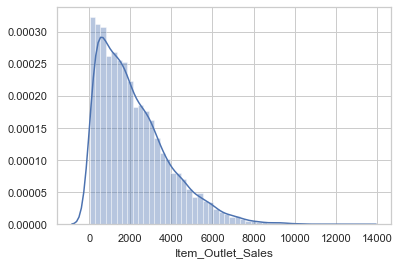

In [157]:
print('skewness for the distribution of Item Outlet Sales is',train['Item_Outlet_Sales'].skew())
print('kurtosis for the distribution of Item Outlet Sales is',train['Item_Outlet_Sales'].kurtosis())
sns.distplot(train.Item_Outlet_Sales)

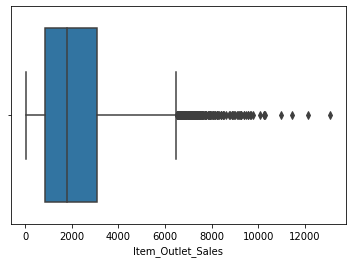

In [25]:
sns.boxplot(data['Item_Outlet_Sales'])

# The distribution of the output is highly skewed and does not follow a parametric distribution. It all has outliers.

# We now need to go for transforming the data as the data is non-linear and for regression it is imperative that we have linear data.
#There are 4 ways of transforming non-linear data:
1) Square transformation

2) Cube root transformation

3) Log transformation

4) Box-Cox Transformation

# We use Square Tranformation, since it gave the least error.

Skewness for this distribution is 0.23467599347099255


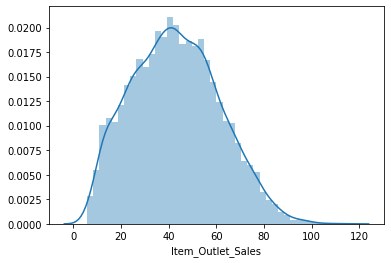

In [26]:
print('Skewness for this distribution is',(train.Item_Outlet_Sales**0.5).skew())
sns.distplot((train.Item_Outlet_Sales**0.5))

# To further establish that the output distribution does not follow normal distribution, we use the Shapiro test for test of normality.

In [27]:
from scipy import stats as sm
sm.shapiro(train.Item_Outlet_Sales)

C:\Users\Navika\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9094116687774658, 0.0)

In [28]:
#------------------------------------------

## Bivariate Analysis:
We will use these analyses to assimilate the strength of the relation between two variables

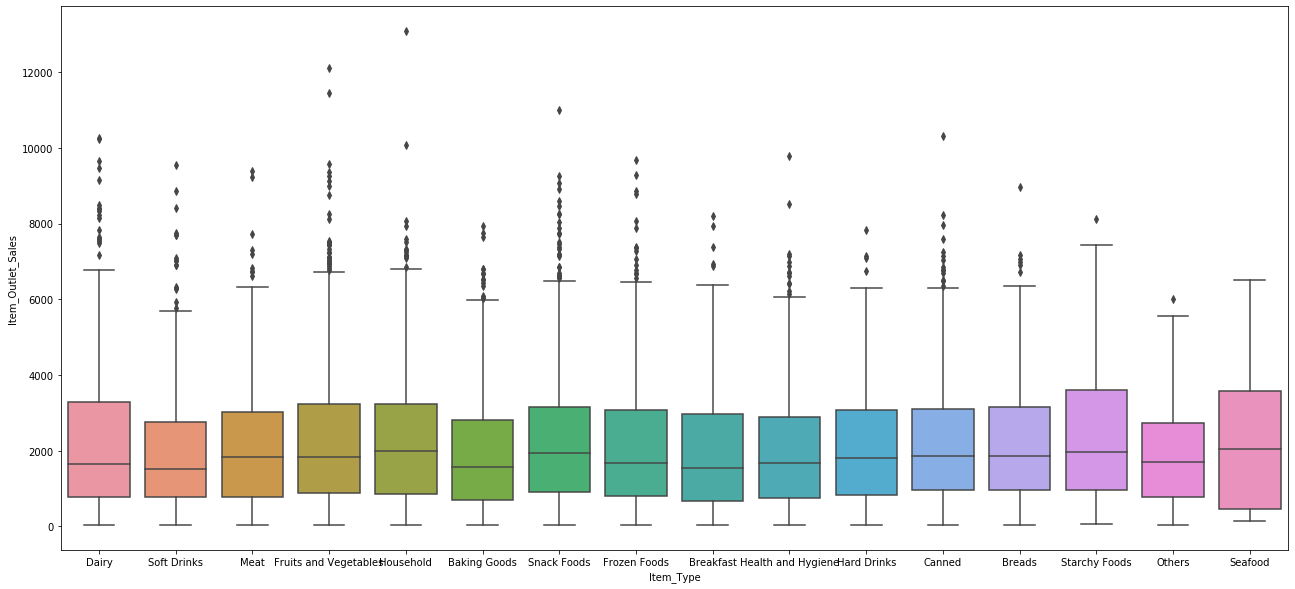

In [29]:
plt.figure(figsize=(22,10))
sns.boxplot(train.Item_Type,y=train.Item_Outlet_Sales)

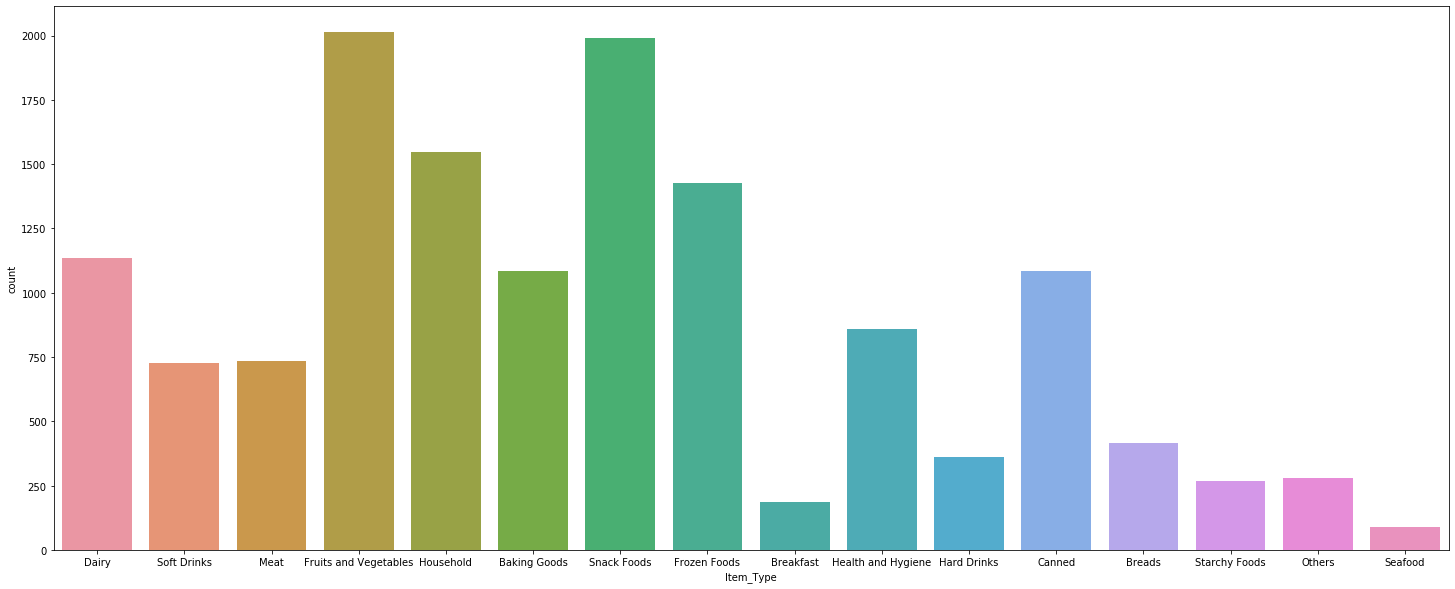

In [30]:
plt.figure(figsize=(25,10))
sns.countplot(data.Item_Type)

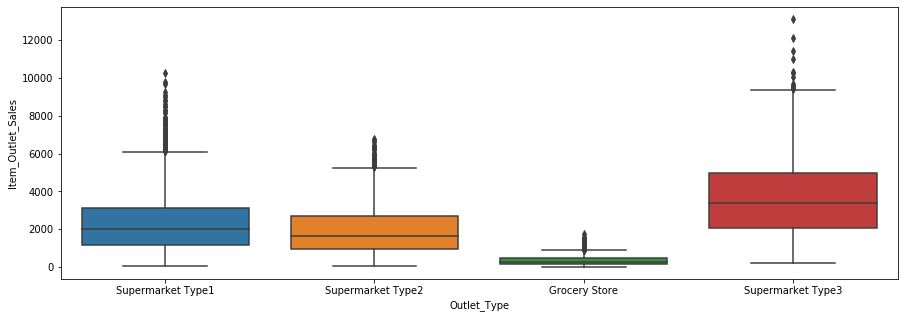

In [31]:
plt.figure(figsize=(15,5))
sns.boxplot(x=train.Outlet_Type,y=train.Item_Outlet_Sales)

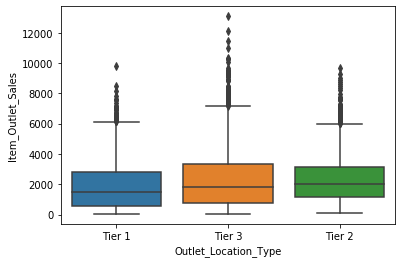

In [32]:
sns.boxplot(x=train.Outlet_Location_Type,y=train.Item_Outlet_Sales)

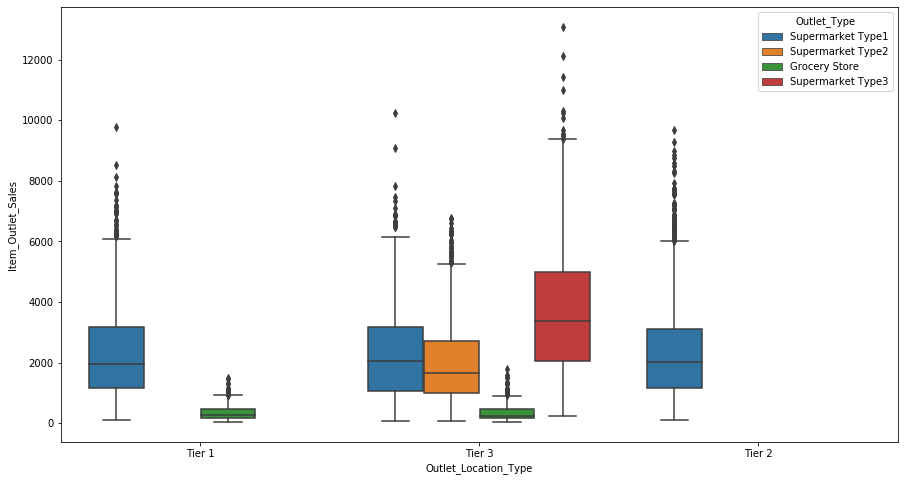

In [33]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train.Outlet_Location_Type,y=train.Item_Outlet_Sales,hue=train.Outlet_Type)


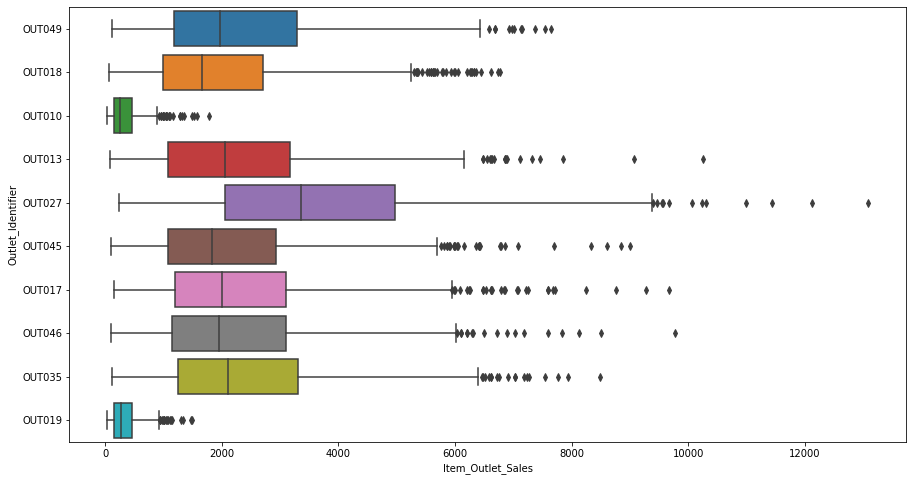

In [34]:
plt.figure(figsize=(15,8))
sns.boxplot(y=train.Outlet_Identifier,x=train.Item_Outlet_Sales)

## The item Sales do vary according to the outlet identifier.  But the average sales for multiple outlet appear to be same, so there is not much variance, thus we will club all those identifiers into one category. So we will have to re-categorie the outlet_identifiers as per their average sales.

In [35]:
data.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean()

Outlet_Identifier
OUT010     339.351662
OUT013    2298.995256
OUT017    2340.675263
OUT018    1995.498739
OUT019     340.329723
OUT027    3694.038558
OUT035    2438.841866
OUT045    2192.384798
OUT046    2277.844267
OUT049    2348.354635
Name: Item_Outlet_Sales, dtype: float64

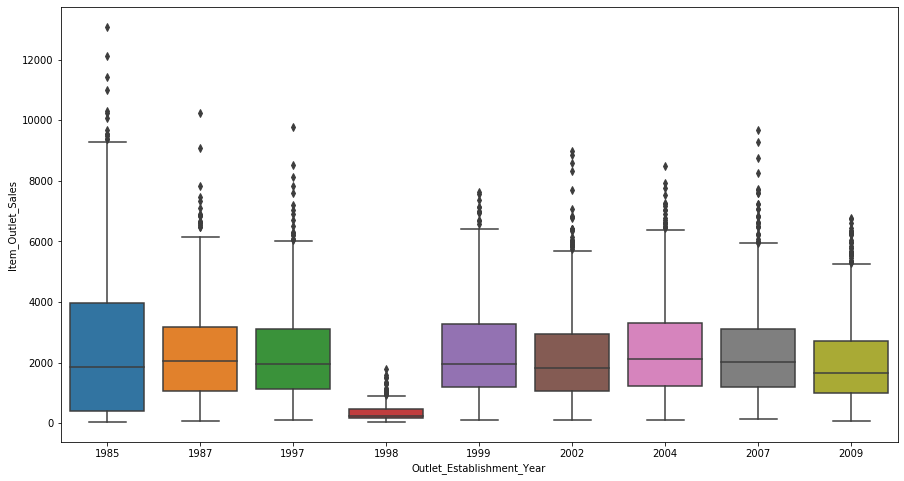

In [36]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train.Outlet_Establishment_Year,y=train.Item_Outlet_Sales)

In [37]:
train.groupby(['Outlet_Establishment_Year'])['Item_Outlet_Sales'].mean()

Outlet_Establishment_Year
1985    2483.677474
1987    2298.995256
1997    2277.844267
1998     339.351662
1999    2348.354635
2002    2192.384798
2004    2438.841866
2007    2340.675263
2009    1995.498739
Name: Item_Outlet_Sales, dtype: float64

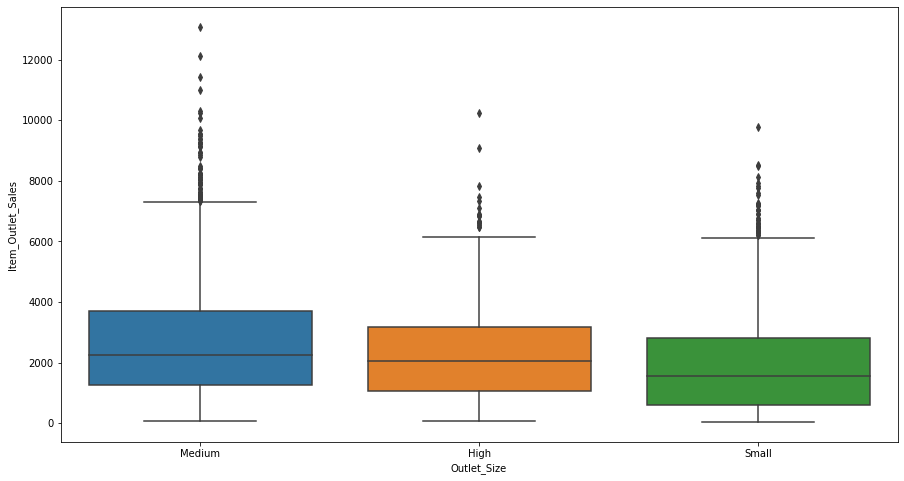

In [38]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train.Outlet_Size,y=train.Item_Outlet_Sales)

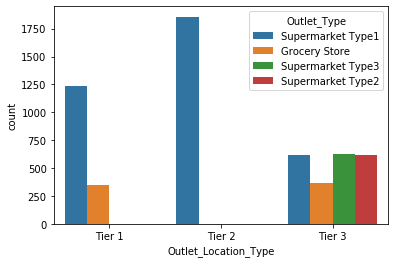

In [39]:
sns.countplot(test.Outlet_Location_Type,hue=test.Outlet_Type)

# Bivariate Analysis for Numerical data

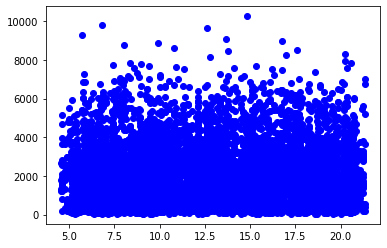

In [40]:
# Item Weight vs Sales
plt.scatter(train.Item_Weight, 
            train.Item_Outlet_Sales, color = "blue")

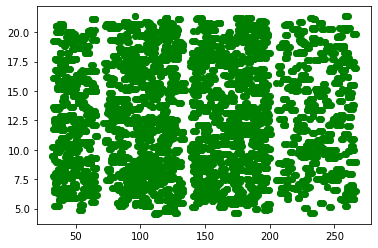

In [41]:
plt.scatter(train.Item_MRP,train.Item_Weight, 
             color = "green")

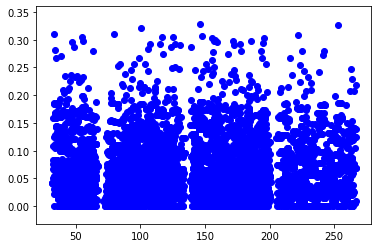

In [42]:
# Item Weight vs Sales
plt.scatter(train.Item_MRP,train.Item_Visibility, 
             color = "blue")

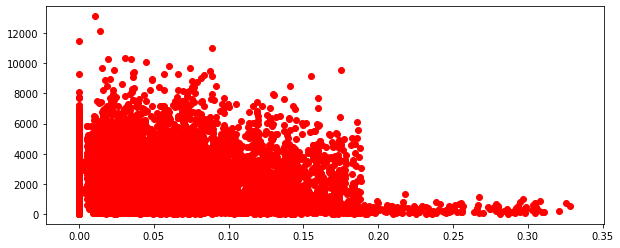

In [43]:
# Item Visibility vs Sales
plt.figure(figsize = [10,4])
plt.scatter(train.Item_Visibility, 
            train.Item_Outlet_Sales, color = "red")

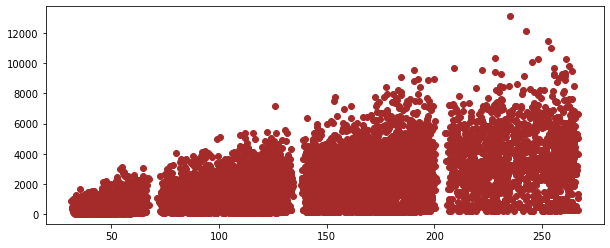

In [44]:
# Item MRP vs Sales
plt.figure(figsize = [10,4])
plt.scatter(x=train.Item_MRP, 
            y=train.Item_Outlet_Sales, color = "brown")

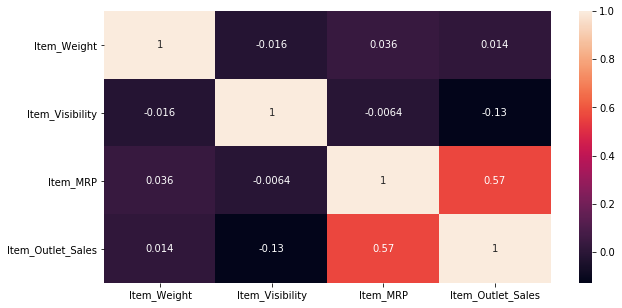

In [45]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),annot=True)

In [46]:
#------------

# The significant variables are Item_Visibility, Item_MRP, Outlet_Establishment_Year, Outlet_Identifier,Outlet_Type.

# Since in our feature selection, Item_Weight and outlet_Size are not significant, so are going to drop them, so there is not a necessity to treat for null values.

# But during our data analysis we notice that the Item_Weight, Fat content, item type are same for every Item_Identifier

In [47]:
data[data['Item_Identifier']=='FDN15']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
2,FDN15,17.5,Low Fat,0.016760,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270
759,FDN15,17.5,Low Fat,0.028009,Meat,141.718,OUT010,1998,NaN,Tier 3,Grocery Store,419.454
4817,FDN15,17.5,Low Fat,0.016720,Meat,139.918,OUT013,1987,High,Tier 3,Supermarket Type1,419.454
5074,FDN15,17.5,Low Fat,0.016802,Meat,138.518,OUT018,2009,Medium,Tier 3,Supermarket Type2,2376.906
6163,FDN15,17.5,Low Fat,0.016768,Meat,141.418,OUT045,2002,NaN,Tier 2,Supermarket Type1,1957.452
6952,FDN15,NaN,Low Fat,0.029299,Meat,140.318,OUT019,1985,Small,Tier 1,Grocery Store,139.818
8349,FDN15,NaN,Low Fat,0.016653,Meat,139.518,OUT027,1985,Medium,Tier 3,Supermarket Type3,2936.178
9682,FDN15,17.5,Low Fat,0.016731,Meat,139.018,OUT035,2004,Small,Tier 2,Supermarket Type1,NaN
12603,FDN15,17.5,Low Fat,0.016829,Meat,138.418,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN
13358,FDN15,17.5,Low Fat,0.000000,Meat,140.418,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN


In [48]:
data[data['Item_Identifier']=='FDX34']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
113,FDX34,NaN,Low Fat,0.071637,Snack Foods,121.7098,OUT027,1985,Medium,Tier 3,Supermarket Type3,4097.3332
2266,FDX34,6.195,Low Fat,0.072097,Snack Foods,119.3098,OUT049,1999,Medium,Tier 1,Supermarket Type1,1205.0980
4709,FDX34,6.195,Low Fat,0.072132,Snack Foods,120.1098,OUT045,2002,NaN,Tier 2,Supermarket Type1,2892.2352
5803,FDX34,6.195,Low Fat,0.072279,Snack Foods,120.6098,OUT018,2009,Medium,Tier 3,Supermarket Type2,1807.6470
7243,FDX34,6.195,Low Fat,0.071986,Snack Foods,122.2098,OUT046,1997,Small,Tier 1,Supermarket Type1,1205.0980
8478,FDX34,6.195,Low Fat,0.071972,Snack Foods,121.3098,OUT035,2004,Small,Tier 2,Supermarket Type1,4820.3920
13571,FDX34,6.195,Low Fat,0.071926,Snack Foods,121.9098,OUT013,1987,High,Tier 3,Supermarket Type1,NaN
13944,FDX34,6.195,Low Fat,0.072393,Snack Foods,122.2098,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN


In [49]:
train[train['Item_Type']=='Snack Foods']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
13,FDS46,17.600,Regular,0.047257,Snack Foods,119.6782,OUT046,1997,Small,Tier 1,Supermarket Type1,2145.2076
20,FDN22,18.850,Regular,0.138190,Snack Foods,250.8724,OUT013,1987,High,Tier 3,Supermarket Type1,3775.0860
26,FDV10,7.645,Regular,0.066693,Snack Foods,42.3112,OUT035,2004,Small,Tier 2,Supermarket Type1,1065.2800
32,FDP33,18.700,Low Fat,0.000000,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
38,FDX10,NaN,Regular,0.123111,Snack Foods,36.9874,OUT027,1985,Medium,Tier 3,Supermarket Type3,388.1614
39,FDB34,NaN,Low Fat,0.026481,Snack Foods,87.6198,OUT027,1985,Medium,Tier 3,Supermarket Type3,2180.4950
42,FDA46,13.600,Low Fat,0.117818,Snack Foods,192.9136,OUT049,1999,Medium,Tier 1,Supermarket Type1,2527.3768
55,FDK21,7.905,Low Fat,0.010053,Snack Foods,249.0408,OUT018,2009,Medium,Tier 3,Supermarket Type2,6258.5200


# Another interesting thing we noticed, that the first two characters in the Item_identifier string were same.
So was the third character comprising of a single alphabet, the last two characters can form another category.

In [50]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

# Intially our model was heavily underfitted so we don't drop Item_Weight and Item_Outlet_Size.

In [51]:
data['Item_Weight']=data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x:x.fillna(x.mean())) 

In [52]:
data.loc[(data.Outlet_Location_Type=='Tier 3')&(data.Outlet_Type=='Grocery Store'),"Outlet_Size"]='Small'

In [53]:
data.loc[(data['Outlet_Type']=='Supermarket Type1')&(data['Outlet_Location_Type']=='Tier 2'),"Outlet_Size"]='Small'

In [54]:
#------------------

In [55]:
idlist = []
for i in data.Item_Identifier:
    idlist.append(str(i)[:2])
    
# combined.Item_Identifier.str[:3]

In [56]:
data["Item_Id_1"] = pd.Series(idlist)

In [57]:
data.Item_Id_1.unique()

array(['FD', 'DR', 'NC'], dtype=object)

In [58]:
idlist2 = []
for i in data.Item_Identifier:
    idlist2.append(str(i)[2:3])

In [59]:
data["Item_Id_2"] = pd.Series(idlist2)

In [60]:
data.Item_Id_2.unique()

array(['A', 'C', 'N', 'X', 'D', 'P', 'O', 'H', 'U', 'Y', 'S', 'F', 'B',
       'I', 'W', 'R', 'V', 'J', 'E', 'Z', 'K', 'L', 'M', 'G', 'Q', 'T'],
      dtype=object)

In [61]:
idlist3 = []
for i in data.Item_Identifier:
    idlist3.append(str(i)[3:])

In [62]:
data["Item_Id_3"] = pd.Series(idlist3)

In [63]:
data.Item_Id_3.unique()

array(['15', '01', '07', '19', '36', '10', '17', '28', '03', '32', '46',
       '49', '42', '11', '02', '22', '12', '30', '37', '06', '59', '51',
       '14', '38', '33', '23', '29', '20', '34', '43', '50', '39', '05',
       '40', '13', '18', '21', '54', '35', '26', '27', '09', '45', '58',
       '48', '04', '25', '55', '44', '41', '56', '57', '47', '60', '52',
       '16', '53', '31', '24', '08'], dtype=object)

In [64]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
Item_Id_1                       0
Item_Id_2                       0
Item_Id_3                       0
dtype: int64

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 15 columns):
Item_Identifier              14204 non-null object
Item_Weight                  14204 non-null float64
Item_Fat_Content             14204 non-null object
Item_Visibility              14204 non-null float64
Item_Type                    14204 non-null object
Item_MRP                     14204 non-null float64
Outlet_Identifier            14204 non-null object
Outlet_Establishment_Year    14204 non-null object
Outlet_Size                  14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Type                  14204 non-null object
Item_Outlet_Sales            8523 non-null float64
Item_Id_1                    14204 non-null object
Item_Id_2                    14204 non-null object
Item_Id_3                    14204 non-null object
dtypes: float64(4), object(11)
memory usage: 1.6+ MB


In [66]:
#------------------------

In [67]:
traindata = data.loc[0:8522]
testdata = data.loc[8523:]

In [68]:
traindata.drop(['Item_Identifier'],axis=1,inplace=True)

C:\Users\Navika\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [69]:
testdata.drop(['Item_Identifier',"Item_Outlet_Sales"],axis=1,inplace=True)

In [70]:
traindata.shape

(8523, 14)

In [71]:
testdata.shape

(5681, 13)

In [72]:
#--------------------

In [73]:
traindummy = pd.get_dummies(traindata)
traindummy = traindummy.transform(lambda x:x**0.5)

In [74]:
traindummy.isnull().sum()

Item_Weight                        0
Item_Visibility                    0
Item_MRP                           0
Item_Outlet_Sales                  0
Item_Fat_Content_Low Fat           0
Item_Fat_Content_Regular           0
Item_Type_Baking Goods             0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen Foods             0
Item_Type_Fruits and Vegetables    0
Item_Type_Hard Drinks              0
Item_Type_Health and Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack Foods              0
Item_Type_Soft Drinks              0
Item_Type_Starchy Foods            0
Outlet_Identifier_OUT010           0
Outlet_Identifier_OUT013           0
Outlet_Identifier_OUT017           0
Outlet_Identifier_OUT018           0
Outlet_Identifier_OUT019           0
O

In [75]:
testdummy = pd.get_dummies(testdata)
testdummy = testdummy.transform(lambda x:x**0.5)

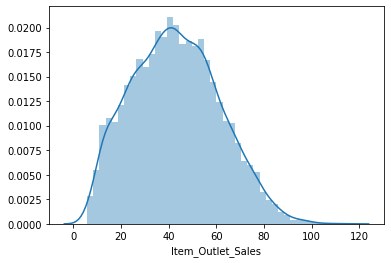

In [76]:
sns.distplot(train.Item_Outlet_Sales**0.5)

In [77]:
traindummy.shape

(8523, 140)

In [78]:
testdummy.shape

(5681, 139)

In [79]:
for x in traindummy.columns:
    if(x not in testdummy.columns):
        print(x)

Item_Outlet_Sales


In [80]:
#Upper_limit = 3101.296400 + 1.5 * (3101.296400-834.247400)

In [81]:
#Upper_limit

In [82]:
#newtrain = newtrain[newtrain['Item_Outlet_Sales']<=Upper_limit]

In [83]:
traindummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Columns: 140 entries, Item_Weight to Item_Id_3_60
dtypes: float64(140)
memory usage: 9.1 MB


In [84]:
testdummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 8523 to 14203
Columns: 139 entries, Item_Weight to Item_Id_3_60
dtypes: float64(139)
memory usage: 6.0 MB


In [85]:
#--------------

In [86]:
x = traindummy.drop(['Item_Outlet_Sales'],axis=1)
y = traindummy['Item_Outlet_Sales']

In [87]:
x

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_Id_3_51,Item_Id_3_52,Item_Id_3_53,Item_Id_3_54,Item_Id_3_55,Item_Id_3_56,Item_Id_3_57,Item_Id_3_58,Item_Id_3_59,Item_Id_3_60
0,3.049590,0.126678,15.805354,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.433105,0.138846,6.947604,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.183300,0.129461,11.900336,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.381780,0.000000,13.494258,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.988311,0.000000,7.339033,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.224128,0.000000,7.169435,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.694591,0.112876,7.593339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.358899,0.357029,10.380857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.024922,0.129179,9.847467,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4.381780,0.307327,13.704795,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Polynomial Regression with Degree=2

In [88]:
x = traindummy.drop(['Item_Outlet_Sales'],axis=1)
y = traindummy['Item_Outlet_Sales']

# Model splitting 80-20

In [89]:
# splitting data as X_train and X_test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2,random_state = 123)

## Linear Regression

In [90]:
# Building the first model with all the features
from sklearn.linear_model import LinearRegression
# instantiate
lm = LinearRegression()

# fit
from sklearn.metrics import r2_score
pred = lm.fit(xtrain,ytrain).predict(xtest)

In [91]:
lm.score(xtrain,ytrain)

0.6686864443162595

In [92]:
lm.score(xtest,ytest)

0.6721827391959019

In [93]:
print(r2_score(y_true=ytest, y_pred=pred))

0.6721827391959019


In [94]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.548703069707901


In [95]:
import statsmodels.api as sm
X_constant = sm.add_constant(xtest)
model = sm.OLS(ytest, X_constant).fit()
predictions = model.predict(X_constant)
model.summary()

C:\Users\Navika\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     33.14
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        02:15:17   Log-Likelihood:                -6355.4
No. Observations:                1705   AIC:                         1.294e+04
Df Residuals:                    1591   BIC:                         1.356e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.7332      0.601     -1.219      0.223      -1.913       0.447
Item_Weight                        -0.0867      0.404     -0.214      0.830      -0.880       0.707
Item_Visibility                    -2.4002      2.565     -0.936      0.349      -7.431       2.630
Item_MRP                            3.7263      0.097     38.291      0.000       3.535       3.917
Item_Fat_Content_Low Fat           -0.8641      0.417     -2.070      0.039      -1.683      -0.045
Item_Fat_Content_Regular            0.1309      0.446      0.293      0.769      -0.745       1.006
Item_Type_Baking Goods             -0.5315      2.264     -0.235      0.814      -4.972       3.909
Item_Type_Breads                    0.7188      2.636      0.273      0.785      -4.452       5.889
Item_Type_Breakfast                -0.5522      2.818     -0.196      0.845      -6.080       4.976
Item_Type_Canned                   -0.4461      1.666     -0.268      0.789      -3.714       2.822
Item_Type_Dairy                    -1.6613      1.811     -0.918      0.359      -5.213       1.890
Item_Type_Frozen Foods              2.0017      2.735      0.732      0.464      -3.364       7.367
Item_Type_Fruits and Vegetables    -1.3956      2.019     -0.691      0.490      -5.356       2.565
Item_Type_Hard Drinks               4.0561      3.441      1.179      0.239      -2.693      10.805
Item_Type_Health and Hygiene        1.4679      2.157      0.680      0.496      -2.764       5.700
Item_Type_Household                 0.1330      1.423      0.093      0.926      -2.659       2.925
Item_Type_Meat                     -1.4528      2.504     -0.580      0.562      -6.365       3.459
Item_Type_Others                   -0.5034      1.965     -0.256      0.798      -4.359       3.352
Item_Type_Seafood                  -4.2971      3.309     -1.298      0.194     -10.788       2.194
Item_Type_Snack Foods              -3.6933      2.226     -1.659      0.097      -8.059       0.672
Item_Type_Soft Drinks               3.5926      3.059      1.174      0.240      -2.408       9.593
Item_Type_Starchy Foods             1.8301      2.581      0.709      0.478      -3.232       6.892
Outlet_Identifier_OUT010           -4.5304      0.297    -15.258      0.000      -5.113      -3.948
Outlet_Identifier_OUT013           -0.5435      0.221     -2.462      0.014      -0.976      -0.110
Outlet_Identifier_OUT017            1.0872      0.341      3.186      0.001       0.418       1.756
Outlet_Identifier_OUT018           -1.1671      0.242     -4.819      0.000      -1.642      -0.692
Outlet_Identifier_OUT019           -5.7477      0.351    -16.355      0.000      -6.437      -5.058
Outlet_Identifier_OUT027            6.1287      0.237     25.806      0.000       5

In [96]:
sns.set(style = 'whitegrid')
residuals = model.resid

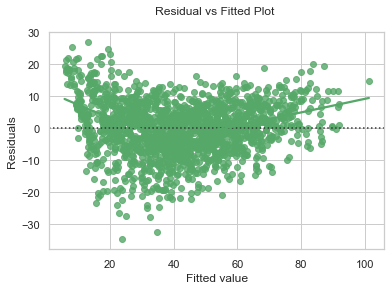

In [97]:
ax = sns.residplot(ytest, residuals, lowess = True, color = 'g')
ax.set(xlabel = 'Fitted value', ylabel = 'Residuals', title = 'Residual vs Fitted Plot \n')
plt.show()

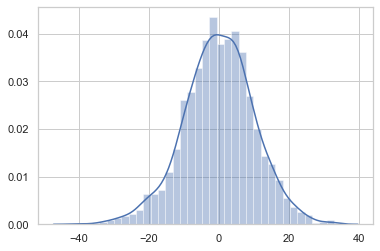

In [98]:
sns.distplot(residuals)

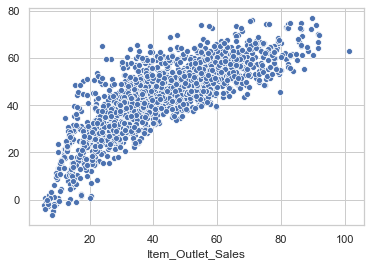

In [99]:
sns.scatterplot(ytest, pred)

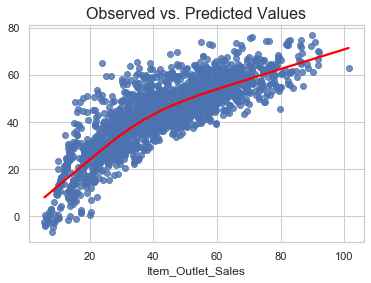

In [100]:
sns.regplot(x=ytest, y=pred, lowess=True, line_kws={'color': 'red'})
plt.title('Observed vs. Predicted Values', fontsize=16)
plt.xlabel='Predicted'
plt.ylabel='Observed'


## Random Forest Regressor

In [102]:
params1 = {'n_estimators':400,
          'min_samples_split':200,
           'min_samples_leaf':3
        }

In [103]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(**params1)
rf.fit(xtrain,ytrain)
pred_rf=rf.predict(xtest)

In [104]:
print(r2_score(y_true=ytest, y_pred=pred_rf))
print(f'R^2 score:{rf.score(xtrain,ytrain)}')
print(f'R^2 score:{rf.score(xtest,ytest)}')

0.6775398824248795
R^2 score:0.7071305608902148
R^2 score:0.6775398824248795


In [105]:
rf.feature_importances_

array([5.41344039e-03, 4.50186923e-03, 4.95685623e-01, 6.88986515e-05,
       6.99774915e-05, 1.17796553e-04, 7.06550010e-05, 2.45149637e-04,
       7.30338492e-05, 2.93899535e-04, 1.63940321e-04, 3.03376824e-04,
       6.51759838e-05, 8.08148413e-05, 4.61113014e-04, 1.27720141e-04,
       9.75650874e-05, 4.79051735e-04, 1.34561576e-04, 2.71521442e-04,
       6.79679783e-05, 0.00000000e+00, 1.01734215e-05, 1.56970772e-04,
       7.30353937e-04, 0.00000000e+00, 2.22626142e-02, 2.38314070e-04,
       3.15885580e-04, 6.36062766e-05, 1.09608732e-04, 2.50050485e-02,
       2.43549486e-05, 1.02619089e-04, 0.00000000e+00, 1.45137611e-04,
       4.42012540e-04, 2.88236028e-04, 1.33268491e-04, 5.76215033e-04,
       2.68713103e-05, 4.25717830e-04, 1.76853990e-04, 1.16978151e-04,
       2.49409882e-04, 4.51492690e-04, 3.94302375e-01, 2.19852909e-03,
       6.60795187e-04, 2.23212171e-02, 2.37592577e-04, 7.29592402e-05,
       9.98877110e-05, 2.51801218e-04, 2.13739696e-04, 8.25358821e-05,
      

In [107]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_rf)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.462155319964898


## XGBoost Regressor

In [108]:
import xgboost as xgb

In [109]:
from xgboost.sklearn import XGBRegressor 
xgb=XGBRegressor() 
preds_xgb=xgb.fit(xtrain,ytrain).predict(xtest)

C:\Users\Navika\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:15:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [110]:
print(r2_score(y_true=ytest, y_pred=preds_xgb))
print(f'R^2 score:{xgb.score(xtrain,ytrain)}')
print(f'R^2 score:{xgb.score(xtest,ytest)}')

0.6827342625576154
R^2 score:0.7013651452907956
R^2 score:0.6827342625576154


In [111]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,preds_xgb)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.377547887166381


## XGBoostRegressor with Hyperparameter Tuning

In [112]:
from xgboost.sklearn import XGBRegressor 
xgb1=XGBRegressor(booster='gblinear',eta=0.3,max_depth = 3,num_boosting_rounds=300,subsample=0.5,
                 tree_method='exact',sample_type='weighted',feature_selector='greedy') 
preds_xgb=xgb.fit(xtrain,ytrain).predict(xtest)

[02:15:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Navika\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [113]:
print(r2_score(y_true=ytest, y_pred=preds_xgb))
print(f'R^2 score:{xgb.score(xtrain,ytrain)}')
print(f'R^2 score:{xgb.score(xtest,ytest)}')

0.6827342625576154
R^2 score:0.7013651452907956
R^2 score:0.6827342625576154


In [114]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,preds_xgb)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.377547887166381


## Gradient Boosting Regressor

In [115]:
params = {'n_estimators': 1000,
          'max_depth': 6,
          'min_samples_split': 50,
          'min_samples_leaf':50,
          'learning_rate': 0.005,
          'min_weight_fraction_leaf':0.0,
          'loss': 'ls'}

In [116]:
from sklearn.ensemble import GradientBoostingRegressor
gbm=GradientBoostingRegressor()
pred_gbm=gbm.fit(xtrain,ytrain).predict(xtest)

In [117]:
print(r2_score(ytest, pred_gbm))
print(f'R^2 score:{gbm.score(xtrain,ytrain)}')
print(f'R^2 score:{gbm.score(xtest,ytest)}')

0.6811602081973491
R^2 score:0.702894586559407
R^2 score:0.6811602081973491


In [118]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_gbm)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.403259163453992


## SVM Regressor

In [119]:
>>> from sklearn.svm import SVR
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.preprocessing import StandardScaler
>>> regr = make_pipeline(StandardScaler(), SVR( epsilon=0.0,kernel='linear'))
>>> regr.fit(xtrain, ytrain)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.0, kernel='linear'))])

In [120]:
pred_svm = regr.predict(xtest)
print(f'R^2 score:{regr.score(xtrain,ytrain)}')
print(f'R^2 score:{regr.score(xtest,ytest)}')

R^2 score:0.665929431393199
R^2 score:0.6684595702935403


In [121]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_svm)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.608437137825238


## Linear SVM Regressor

In [122]:
>>> from sklearn.svm import LinearSVR
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.preprocessing import StandardScaler
>>> regrl = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
>>> regrl.fit(xtrain, ytrain)

C:\Users\Navika\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=0, tol=1e-05))])

In [123]:
pred_svr = regrl.predict(xtest)
print(f'R^2 score:{regrl.score(xtrain,ytrain)}')
print(f'R^2 score:{regrl.score(xtest,ytest)}')

R^2 score:0.665905723284282
R^2 score:0.6685266486312376


In [124]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_svr)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.607363916791282


## Nu SVM Regressor

In [125]:
>>> from sklearn.svm import NuSVR
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.preprocessing import StandardScaler
>>> nregr = make_pipeline(StandardScaler(), NuSVR(kernel='linear',nu=0.7))
>>> nregr.fit(xtrain, ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nusvr', NuSVR(kernel='linear', nu=0.7))])

In [126]:
pred_nusvr = nregr.predict(xtest)
print(f'R^2 score:{nregr.score(xtrain,ytrain)}')
print(f'R^2 score:{nregr.score(xtest,ytest)}')

R^2 score:0.6668116354953382
R^2 score:0.6704286023503474


In [127]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_nusvr)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.576888256366546


## Ada Regression

In [128]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor 
ada = AdaBoostRegressor(random_state=0, n_estimators=100,loss='linear',learning_rate=0.05,
                       base_estimator=LinearRegression())
pred_ada = ada.fit(xtrain, ytrain).predict(xtest)

In [129]:
print(f'R^2 score:{ada.score(xtrain,ytrain)}')
print(f'R^2 score:{ada.score(xtest,ytest)}')

R^2 score:0.6662967617036228
R^2 score:0.6705534878986976


In [130]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_ada)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.574884099367278


## Bagging Regressor

In [131]:
from sklearn.linear_model import Ridge

In [132]:
>>> from sklearn.ensemble import BaggingRegressor
>>> bag = BaggingRegressor(base_estimator=Ridge()).fit(xtrain,ytrain)
pred_bag=bag.predict(xtest)
print(f'R^2 score:{bag.score(xtrain,ytrain)}')
print(f'R^2 score:{bag.score(xtest,ytest)}')

R^2 score:0.6681671949716828
R^2 score:0.6722084000926721


In [133]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_bag)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.54829019566135


## KNN Regressor

In [137]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=40)
pred_knn=knn.fit(xtrain, ytrain).predict(xtest)

In [138]:
print(f'R^2 score:{knn.score(xtrain,ytrain)}')
print(f'R^2 score:{knn.score(xtest,ytest)}')

R^2 score:0.6841303260935931
R^2 score:0.6793378461804729


In [139]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(ytest,pred_knn)
lr_rmse_score=np.sqrt(mse)
print(lr_rmse_score)

10.432947257841203


# Final Results and Observations with Prediction on Unseen Data

# Results - WithOut Removal of Insignificant Features

In [140]:
Result_Summary1 = pd.DataFrame({
                                'Algorithm':['Polynomial Regression','Linear Regression','Random Forest','XGBoost','Gradient Boosting','SVM','Linear SVM','NuSVM','AdaBoost','Knn Model','Bagging regressor','LassoLars'],
                                'RMSE Error':['Very High Error',1155.95,1150,1152.94,1155.1,1167,1167.27,1164,1157,1154,1157, 1180]
})
Result_Summary1

,Algorithm,RMSE Error
0,Polynomial Regression,Very High Error
1,Linear Regression,1155.95
2,Random Forest,1150
3,XGBoost,1152.94
4,Gradient Boosting,1155.1
5,SVM,1167
6,Linear SVM,1167.27
7,NuSVM,1164
8,AdaBoost,1157
9,Knn Model,1154


# Results - With Removal of Insignificant variables

In [141]:
Result_Summary2 = pd.DataFrame({
                                'Algorithm':['Polynomial Regression','Linear Regression','Random Forest','XGBoost','Gradient Boosting','SVM','AdaBoost','Knn Model','Bagging regressor','Linear SVM'],
                                'RMSE Error':[1169.35,1171,1148.55,1161,1185,1184,1161,1251,1170,1189]
})
Result_Summary2

,Algorithm,RMSE Error
0,Polynomial Regression,1169.35
1,Linear Regression,1171.00
2,Random Forest,1148.55
3,XGBoost,1161.00
4,Gradient Boosting,1185.00
5,SVM,1184.00
6,AdaBoost,1161.00
7,Knn Model,1251.00
8,Bagging regressor,1170.00
9,Linear SVM,1189.00


Final Obseravtions:
1) The model was transformed before training and testing. When the input was transformed for non-linearity as well, so that gave us our best result.

2) When more features are introduced through feature extraction and feature transformation, accuracy increases but rmse error increases or doesnt get affected.

3) Rmse gets affected due to high multicolinearity amonsgt varibles. But if those variables are dropped which show high multicollinearity, the accuracy is compromised.

4) Outlier removal didn't help with the model because they reduce the variance, and then the model underperformed.

5)So it seems that the highest accuarcy possible is 68-69%, as there are too many categorical variables. The data was already non-liear on top of that.

6) We tranformed the whole dataset and our accuracy score got a little better.


# Predictions with the unseen data and the rmse error.

In [142]:
pred_lm2 = lm.fit(xtrain,ytrain).predict(testdummy)

In [143]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(**params1)
rf.fit(xtrain,ytrain)
pred_rf2=rf.predict(testdummy)

In [144]:
xgb=XGBRegressor() 
preds_xgb2=xgb.fit(xtrain,ytrain).predict(testdummy)

C:\Users\Navika\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:17:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [145]:
from sklearn.ensemble import GradientBoostingRegressor
gbm=GradientBoostingRegressor(**params)
pred_gbm21=gbm.fit(xtrain,ytrain).predict(testdummy)

In [146]:
>>> from sklearn.svm import SVR
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.preprocessing import StandardScaler
>>> svm = make_pipeline(StandardScaler(), SVR( epsilon=0.0,kernel='linear'))
>>> pred_svm2 = svm.fit(xtrain, ytrain).predict(testdummy)

In [147]:
pred_svr2 = regrl.fit(xtrain, ytrain).predict(testdummy)

C:\Users\Navika\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [148]:
pred_nregr2 = nregr.fit(xtrain,ytrain).predict(testdummy)

In [149]:
pred_ada2 = ada.fit(xtrain,ytrain).predict(testdummy)

In [150]:
pred_bag2 = bag.fit(xtrain,ytrain).predict(testdummy)

In [151]:
from sklearn import linear_model
regl = linear_model.LassoLarsIC(criterion='aic')
pred_regl2 = regl.fit(xtrain,ytrain).predict(testdummy)

C:\Users\Navika\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.912e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Navika\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.912e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Navika\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.698e-03, with an active set of 15 regressors, and the smallest choles